In [20]:
import sys
import os
import importlib
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

import dart.Util
import dart.metrics.start_calculations

from dart.handler.NLP.sentiment import Sentiment
import ast
import difflib
from dart.handler.NLP.enrich_entities import EntityEnricher
from tqdm import tqdm
import requests
from datetime import datetime

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [21]:
config = {
    'test_size': 10000, 
    'metrics':  ['calibration', 'fragmentation', 'activation', 'representation', 'alternative_voices'],
    'cutoff': [1, 2, 5, 10, 20, 0],
    'algorithms': ['lstur', 'naml', 'npa', 'nrms', 'pop', 'random'],
    'output_folder': '_TFM/output/',
    'language': 'english',
    'country': 'us'
}

In [22]:
behavior_file = dart.Util.read_behavior_file("_TFM/dev_behaviors.tsv")

In [23]:
behavior_file[1]

{'impression_index': 2,
 'userid': 'U60458',
 'date': datetime.datetime(2019, 11, 15, 7, 11, 50),
 'history': ['N58715',
  'N32109',
  'N51180',
  'N33438',
  'N54827',
  'N28488',
  'N61186',
  'N34775',
  'N33742',
  'N50020',
  'N57061',
  'N30924',
  'N6778'],
 'items': ['N20036-0',
  'N23513-1',
  'N32536-0',
  'N46976-0',
  'N35216-0',
  'N36779-0',
  'N31958-0'],
 'items_without_click': ['N20036',
  'N23513',
  'N32536',
  'N46976',
  'N35216',
  'N36779',
  'N31958']}

In [24]:
reco_lstur = pd.read_json("_TFM/lstur_pred_small.json", lines=True)
reco_nrms = pd.read_json("_TFM/nrms_pred_small.json", lines=True)
reco_naml = pd.read_json("_TFM/naml_pred_small.json", lines=True)
reco_npa = pd.read_json("_TFM/npa_pred_small.json", lines=True)
reco_pop = pd.read_json("_TFM/pop_pred_small.json", lines=True)
reco_random = pd.read_json("_TFM/random_pred_small.json", lines=True)

reco_lstur = reco_lstur.set_index("impr_index")
reco_naml  = reco_naml.set_index("impr_index")
reco_nrms  = reco_nrms.set_index("impr_index")
reco_npa   = reco_npa.set_index("impr_index")
reco_pop   = reco_pop.set_index("impr_index")
reco_random   = reco_random.set_index("impr_index")

reco_lstur = reco_lstur.rename(columns={"pred_rank": "lstur"})
reco_naml  = reco_naml.rename(columns={"pred_rank": "naml"})
reco_nrms  = reco_nrms.rename(columns={"pred_rank": "nrms"})
reco_npa   = reco_npa.rename(columns={"pred_rank": "npa"})
reco_pop   = reco_pop.rename(columns={"pred_rank": "pop"})
reco_random   = reco_random.rename(columns={"pred_rank": "random"})

recommendations_raw = reco_lstur.join([reco_naml, reco_nrms, reco_npa, reco_pop, reco_random])

recommendations_raw.head(10)

,lstur,naml,nrms,npa,pop,random
impr_index,,,,,,
1,"[6, 7, 14, 9, 3, 13, 22, 4, 2, 21, 8, 17, 18, ...","[12, 5, 10, 6, 4, 9, 22, 15, 2, 14, 7, 3, 13, ...","[16, 1, 8, 7, 5, 14, 21, 6, 2, 22, 12, 4, 20, ...","[1, 20, 5, 15, 12, 6, 19, 18, 8, 21, 16, 4, 2,...","[3, 12, 8, 6, 18, 15, 9, 21, 22, 16, 7, 5, 13,...","[3, 10, 9, 13, 0, 16, 14, 8, 2, 21, 1, 11, 20,..."
2,"[5, 1, 7, 6, 3, 2, 4]","[4, 2, 3, 5, 7, 6, 1]","[2, 1, 4, 6, 3, 7, 5]","[4, 1, 7, 6, 3, 5, 2]","[7, 6, 1, 2, 3, 5, 4]","[1, 2, 6, 4, 0, 5, 3]"
3,"[15, 12, 11, 3, 17, 19, 8, 16, 6, 9, 22, 5, 23...","[17, 7, 12, 6, 21, 19, 11, 22, 9, 5, 18, 3, 20...","[19, 8, 9, 4, 11, 17, 13, 18, 5, 16, 20, 2, 22...","[19, 18, 11, 5, 12, 6, 8, 21, 9, 22, 15, 4, 20...","[12, 1, 14, 9, 17, 15, 4, 21, 20, 7, 23, 16, 1...","[14, 9, 3, 10, 7, 18, 5, 13, 6, 21, 12, 1, 4, ..."
4,"[8, 20, 18, 24, 19, 5, 17, 7, 13, 9, 23, 2, 16...","[14, 22, 25, 21, 11, 3, 20, 23, 15, 6, 17, 4, ...","[5, 11, 18, 16, 12, 1, 10, 20, 21, 8, 15, 4, 1...","[10, 7, 24, 14, 11, 19, 22, 21, 23, 26, 17, 16...","[6, 25, 20, 19, 14, 5, 16, 7, 10, 18, 24, 23, ...","[6, 20, 8, 17, 1, 19, 9, 10, 24, 7, 16, 4, 22,..."
5,"[10, 2, 4, 14, 7, 3, 12, 1, 11, 8, 9, 6, 13, 5]","[8, 2, 9, 14, 6, 3, 10, 1, 13, 5, 11, 4, 12, 7]","[10, 1, 5, 14, 7, 3, 8, 2, 11, 6, 12, 9, 13, 4]","[3, 1, 5, 14, 6, 4, 12, 2, 7, 10, 13, 9, 11, 8]","[6, 13, 1, 14, 2, 8, 5, 3, 11, 12, 10, 9, 7, 4]","[6, 3, 2, 1, 13, 7, 11, 4, 9, 5, 12, 10, 0, 8]"
6,"[11, 8, 10, 6, 7, 3, 2, 9, 5, 4, 1]","[11, 10, 8, 2, 5, 4, 3, 9, 7, 6, 1]","[9, 6, 11, 8, 3, 1, 4, 10, 7, 5, 2]","[8, 11, 7, 3, 5, 9, 1, 10, 4, 6, 2]","[11, 6, 4, 5, 3, 10, 1, 7, 2, 9, 8]","[4, 5, 0, 6, 1, 2, 7, 8, 3, 9, 10]"
7,"[3, 1, 4, 2, 6, 7, 5]","[5, 1, 4, 3, 7, 2, 6]","[3, 1, 7, 2, 6, 4, 5]","[5, 1, 6, 4, 7, 2, 3]","[7, 3, 6, 4, 2, 5, 1]","[3, 0, 5, 4, 2, 1, 6]"
8,"[23, 1, 12, 8, 2, 38, 31, 14, 3, 34, 41, 29, 3...","[31, 4, 13, 25, 1, 26, 32, 23, 2, 18, 41, 16, ...","[29, 4, 12, 19, 3, 37, 27, 18, 1, 25, 41, 36, ...","[35, 3, 26, 11, 7, 19, 25, 9, 5, 27, 39, 22, 3...","[26, 9, 28, 37, 18, 32, 27, 23, 14, 10, 40, 2,...","[2, 17, 39, 1, 20, 14, 11, 26, 31, 12, 24, 33,..."
9,"[4, 2, 1, 3]","[4, 3, 1, 2]","[2, 4, 3, 1]","[3, 2, 4, 1]","[3, 2, 4, 1]","[0, 3, 2, 1]"


In [25]:
def get_recommendations_newsID():
    """
    Reordena todas las listas de recomendaciones de índices numéricos
    a listas de news_id según behaviors_file['items_without_click'].

    Requiere que existan:
        - behavior_file : lista de diccionarios con 'items_without_click'
        - recommendations_raw : DataFrame con columnas de modelos, celdas = listas de índices/ranks
    Devuelve:
        - recommendations : DataFrame con mismas columnas, pero con listas de news_id reordenadas
    """
    
    def reorder_by_rank(items, ranks):
        if len(items) != len(ranks):
            raise ValueError(f"Items and ranks must have the same length ({len(items)} != {len(ranks)})")
        paired = list(zip(items, ranks))
        ordered = sorted(paired, key=lambda x: x[1])
        return [item for item, _ in ordered]

    # Crear DataFrame vacío con la misma estructura
    recommendations = pd.DataFrame(index=recommendations_raw.index, columns=recommendations_raw.columns)

    # Reordenar todas las filas y columnas
    for idx, row in recommendations_raw.iterrows():
        items = behavior_file[idx-1]['items_without_click']
        
        for model_name in recommendations_raw.columns:
            ranks = row[model_name]
            recommendations.at[idx, model_name] = reorder_by_rank(items, ranks)
    
    return recommendations

In [26]:
recommendations = get_recommendations_newsID()

In [27]:
recommendations.head()

,lstur,naml,nrms,npa,pop,random
impr_index,,,,,,
1,"[N42844, N19990, N6916, N24802, N55237, N28682...","[N42844, N19990, N5940, N6916, N48740, N34130,...","[N48740, N19990, N53572, N5940, N6916, N24802,...","[N28682, N6400, N42844, N5940, N31958, N5472, ...","[N55237, N58098, N28682, N51470, N5940, N34130...","[N6916, N62365, N19990, N28682, N21679, N58098..."
2,"[N23513, N36779, N35216, N31958, N20036, N4697...","[N31958, N23513, N32536, N20036, N46976, N3677...","[N23513, N20036, N35216, N32536, N31958, N4697...","[N23513, N31958, N35216, N20036, N36779, N4697...","[N32536, N46976, N35216, N31958, N36779, N2351...","[N35216, N20036, N23513, N31958, N46976, N3677..."
3,"[N30290, N42844, N5472, N6916, N31958, N20036,...","[N30290, N6916, N31958, N42844, N47383, N5472,...","[N30290, N31958, N6916, N5472, N20036, N53572,...","[N42844, N30290, N5940, N31958, N5472, N55036,...","[N62365, N49285, N16680, N19990, N53572, N6916...","[N16680, N31958, N6916, N58098, N50775, N19990..."
4,"[N1952, N15347, N52492, N60762, N24802, N6400,...","[N1952, N52492, N24802, N15347, N60762, N51470...","[N24802, N1952, N52492, N15347, N6950, N60762,...","[N6400, N1952, N49285, N19990, N19611, N52492,...","[N19990, N29091, N52492, N6400, N24802, N6950,...","[N29862, N6916, N19611, N60762, N15347, N49285..."
5,"[N30290, N23513, N31958, N49285, N20036, N3413...","[N30290, N23513, N31958, N34130, N62365, N1999...","[N23513, N30290, N31958, N20036, N49285, N6236...","[N23513, N30290, N5940, N31958, N49285, N19990...","[N49285, N19990, N30290, N20036, N29393, N5940...","[N36779, N23355, N49285, N23513, N30290, N6236..."


In [28]:
# Hace multiples requests y en el resultado no hay ningun QID, salen los strings que toque
def get_wikidata_info_mult(qid):
    """
    Devuelve un diccionario con:
    - text: label en inglés
    - party: partido político principal/actual en inglés (P102)
    - givenname: lista de nombres de pila en inglés (P735)
    """
    headers = {"User-Agent": "MyPythonApp/1.0 (contact: tu_email@ejemplo.com)"}

    def parse_wikidata_time(time_str):
        """Convierte '+YYYY-MM-DDT...' a datetime.date, reemplazando día 00 por 01"""
        if not time_str:
            return None
        if time_str.startswith('+'):
            time_str = time_str[1:]
        date_part = time_str.split('T')[0]
        parts = date_part.split('-')
        if len(parts) == 3 and parts[2] == '00':
            parts[2] = '01'
        try:
            return datetime.strptime('-'.join(parts), '%Y-%m-%d').date()
        except ValueError:
            return None

    # 1. Obtener entidad principal
    url = f"https://www.wikidata.org/wiki/Special:EntityData/{qid}.json"
    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        print(f"Error {r.status_code} al consultar {qid}")
        return {}

    entity = r.json()['entities'][qid]
    result = {}

    # text → label en inglés
    result['text'] = entity['labels'].get('en', {}).get('value', None)

    # 2. Obtener partido principal/actual (P102)
    parties_claims = entity.get('claims', {}).get('P102', [])
    today = datetime.today().date()
    party_label = None
    for claim in parties_claims:
        mainsnak = claim.get('mainsnak', {})
        datavalue = mainsnak.get('datavalue', {})
        party_qid = datavalue.get('value', {}).get('id')
        if not party_qid:
            continue

        # Revisar fechas
        qualifiers = claim.get('qualifiers', {})
        end_dates = qualifiers.get('P582', [])
        active = True
        for end in end_dates:
            time_val = end.get('datavalue', {}).get('value', {}).get('time')
            end_date = parse_wikidata_time(time_val)
            if end_date and end_date < today:
                active = False
                break

        if active:
            # Obtener label en inglés del partido
            party_url = f"https://www.wikidata.org/wiki/Special:EntityData/{party_qid}.json"
            r_party = requests.get(party_url, headers=headers)
            if r_party.status_code != 200:
                party_label = party_qid
            else:
                party_data = r_party.json()['entities'][party_qid]
                party_label = party_data['labels'].get('en', {}).get('value', party_qid)
            break  # tomar solo el primero activo
    result['party'] = party_label

    # 3. Obtener givenname → lista de labels en inglés (P735)
    given_claims = entity.get('claims', {}).get('P735', [])
    givennames_text = []
    for claim in given_claims:
        mainsnak = claim.get('mainsnak', {})
        datavalue = mainsnak.get('datavalue', {})
        given_qid = datavalue.get('value', {}).get('id')
        if not given_qid:
            continue
        # Obtener label en inglés
        q_url = f"https://www.wikidata.org/wiki/Special:EntityData/{given_qid}.json"
        rq = requests.get(q_url, headers=headers)
        if rq.status_code != 200:
            givennames_text.append(given_qid)
        else:
            given_entity = rq.json()['entities'][given_qid]
            label = given_entity['labels'].get('en', {}).get('value', given_qid)
            givennames_text.append(label)
    result['givenname'] = givennames_text if givennames_text else None

    return result

In [29]:
# Ejemplo de uso
qid = "Q22686"  # Donald Trump
info = get_wikidata_info_mult(qid)
print(info)

{'text': 'Donald Trump', 'party': 'Republican Party', 'givenname': ['Donald', 'John']}


In [30]:
print(get_wikidata_info_mult("Q7608401")) # Stephanie Stahl

Error 404 al consultar Q7608401
{}


In [31]:
print(get_wikidata_info_mult("Q7407755")) # Sam Kouvaris

Error 404 al consultar Q7407755
{}


In [32]:
# Una sola request, mas rapido
def get_wikidata_info(qid):
    """
    Devuelve un diccionario con:
    - text: label en inglés
    - party: QID del partido actual (P102) basado en fechas P580/P582
    - givenname: lista de QIDs de nombres de pila (P735)
    """
    headers = {"User-Agent": "MyPythonApp/1.0 (contact: tu_email@ejemplo.com)"}
    today = datetime.today().date()

    def parse_wikidata_time(time_str):
        """Convierte '+YYYY-MM-DDT...' a datetime.date, reemplazando día 00 por 01"""
        if not time_str:
            return None
        if time_str.startswith('+'):
            time_str = time_str[1:]
        date_part = time_str.split('T')[0]
        parts = date_part.split('-')
        if len(parts) == 3 and parts[2] == '00':
            parts[2] = '01'
        try:
            return datetime.strptime('-'.join(parts), '%Y-%m-%d').date()
        except ValueError:
            return None

    # 1. Obtener entidad principal
    url = f"https://www.wikidata.org/wiki/Special:EntityData/{qid}.json"
    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        print(f"Error {r.status_code} al consultar {qid}")
        return {}

    entity = r.json()['entities'][qid]
    result = {}

    # text → label en inglés
    result['text'] = entity['labels'].get('en', {}).get('value', None)

    # 2. Obtener party actual → solo QID
    parties_claims = entity.get('claims', {}).get('P102', [])
    current_party_qid = None
    for claim in parties_claims:
        mainsnak = claim.get('mainsnak', {})
        datavalue = mainsnak.get('datavalue', {})
        pqid = datavalue.get('value', {}).get('id')
        if not pqid:
            continue

        # Revisar fechas P580/P582
        qualifiers = claim.get('qualifiers', {})
        start_dates = qualifiers.get('P580', [])
        end_dates = qualifiers.get('P582', [])
        start_ok = True
        end_ok = True

        # start date check (opcional)
        if start_dates:
            start_time = start_dates[0].get('datavalue', {}).get('value', {}).get('time')
            start_date = parse_wikidata_time(start_time)
            if start_date and start_date > today:
                start_ok = False

        # end date check
        if end_dates:
            end_time = end_dates[0].get('datavalue', {}).get('value', {}).get('time')
            end_date = parse_wikidata_time(end_time)
            if end_date and end_date < today:
                end_ok = False

        if start_ok and end_ok:
            current_party_qid = pqid
            break  # Tomar solo el primero válido activo

    result['party'] = [current_party_qid] if current_party_qid else []

    # 3. Obtener givenname → solo QIDs
    given_claims = entity.get('claims', {}).get('P735', [])
    given_qids = []
    for claim in given_claims:
        mainsnak = claim.get('mainsnak', {})
        datavalue = mainsnak.get('datavalue', {})
        gqid = datavalue.get('value', {}).get('id')
        if gqid:
            given_qids.append(gqid)
    result['givenname'] = given_qids if given_qids else None

    return result

In [33]:
# Ejemplo de uso
qid = "Q22686"  # Donald Trump
info = get_wikidata_info(qid)
print(info)

{'text': 'Donald Trump', 'party': ['Q29468'], 'givenname': ['Q13422248', 'Q4925477']}


In [34]:
def convert_entities(row):
    # convertir strings a listas
    title = ast.literal_eval(row['title_entities']) if isinstance(row['title_entities'], str) else row['title_entities'] or []
    abstract = ast.literal_eval(row['abstract_entities']) if isinstance(row['abstract_entities'], str) else row['abstract_entities'] or []

    # combinar
    combined = title + abstract

    # asegurarnos de que sea lista
    if combined is None or not isinstance(combined, list):
        combined = []

    new_list = []
    for e in combined:
        #print("label original: ", e)
        label = 'PERSON' if e.get('Type') == 'P' else ('ORG' if e.get('Type') == 'O' else e.get('Type',''))
        text = e.get('Label', '')
        spans = e.get('OccurrenceOffsets', [])

        # enrich con wikidata_id solo si es persona
        party = []
        givenname = []
        if label == 'PERSON':
            try:
                e_enriched = get_wikidata_info(e.get('WikidataId'))
                
                #print(e_enriched)
                
                if(len(e_enriched['party']) > 0):
                    if(e_enriched['party'][0]=='Q29552'):
                        party = ['Democratic Party']
                    elif(e_enriched['party'][0]=='Q29468'):
                        party = ['Republican Party']

                if(len(e_enriched['givenname'])>0):
                    givenname = e_enriched['givenname']

            except Exception:
                pass

        if givenname:
            new_list.append({
            'label': label,
            'text': text,
            'spans': spans,
            'party': party,
            'givenname': givenname
            })
        else:
            new_list.append({
            'label': label,
            'text': text,
            'spans': spans,
            'party': party
            })

    return new_list

In [13]:
# story = title // text = abstract
columnas = ["news_id", "category", "subcategory", "story", "text", "url", "title_entities", "abstract_entities", ]
articles = pd.read_csv("_TFM/dev_news.tsv", sep="\t", header=None, names=columnas)
articles = articles.set_index("news_id")
articles['text'] = articles['text'].fillna(articles['story'].fillna('')).astype(str).str.strip() # evitamos nans y '' poniendo titulo si no hay text
articles['story'] = articles['story'].fillna(articles['story']).fillna('').astype(str).str.strip()

In [14]:
sentiment_analyzer = Sentiment(language='english')
articles['sentiment'] = articles['text'].apply(lambda x: sentiment_analyzer.get_sentiment_score(x) if isinstance(x, str) else 0)

In [15]:
articles.head()

,category,subcategory,story,text,url,title_entities,abstract_entities,sentiment
news_id,,,,,,,,
N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],0.318182
N18955,health,medical,Dispose of unwanted prescription drugs during ...,Dispose of unwanted prescription drugs during ...,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[],0.000000
N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",-0.033333
N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",0.100000
N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",0.580000


In [16]:
# entities en title: 49.910 /// entities en abstract: 77.059 --> total 126.969. Tarda unas 5h 25min con convert_entities
tqdm.pandas()
articles['entities'] = articles.progress_apply(convert_entities, axis=1)
articles.drop(columns=['title_entities', 'abstract_entities', 'url'], inplace=True)

 39%|████████████████████████████▎                                           | 16686/42416 [2:07:19<3:08:50,  2.27it/s]

Error 404 al consultar Q7608401


 73%|████████████████████████████████████████████████████▏                   | 30766/42416 [3:57:50<1:41:28,  1.91it/s]

Error 404 al consultar Q7407755


100%|██████████████████████████████████████████████████████████████████████████| 42416/42416 [5:24:18<00:00,  2.18it/s]


In [17]:
# Guardar
articles.to_pickle("_TFM/output/articles_processed.pkl")

In [20]:
articles.entities.iloc[0]

[{'label': 'PERSON',
  'text': 'Prince Philip, Duke of Edinburgh',
  'spans': [48],
  'party': [],
  'givenname': ['Q827311']},
 {'label': 'PERSON',
  'text': 'Charles, Prince of Wales',
  'spans': [28],
  'party': [],
  'givenname': ['Q2958359', 'Q827311', 'Q1778168', 'Q15921732', 'Q59206706']},
 {'label': 'PERSON',
  'text': 'Elizabeth II',
  'spans': [11],
  'party': [],
  'givenname': ['Q385468', 'Q6081128', 'Q734578']}]

In [15]:
# Cargar fichero guardado
articles_loaded = pd.read_pickle("_TFM/output/articles_processed.pkl")

#Lo cargamos en la variable original
articles = articles_loaded
articles.head()

,category,subcategory,story,text,sentiment,entities
news_id,,,,,,
N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",0.318182,"[{'label': 'PERSON', 'text': 'Prince Philip, D..."
N18955,health,medical,Dispose of unwanted prescription drugs during ...,Dispose of unwanted prescription drugs during ...,0.000000,"[{'label': 'ORG', 'text': 'Drug Enforcement Ad..."
N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,-0.033333,"[{'label': 'G', 'text': 'Ukraine', 'spans': [8..."
N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",0.100000,"[{'label': 'ORG', 'text': 'National Basketball..."
N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",0.580000,"[{'label': 'C', 'text': 'Skin tag', 'spans': [..."


In [16]:
count_entities = sum(
    1
    for _, article in articles.iterrows()
    for person in article['entities']  # nota que es article['entities'], no articles['entities']
    if person.get('label') == 'PERSON' and 'givenname' in person and len(person['givenname'])>0
)
total_persons = sum(
    1
    for _, article in articles.iterrows()
    for person in article['entities']
    if person.get('label') == 'PERSON'
)
print(f"personas con givenname del total: {count_entities}/{total_persons}")

personas con givenname del total: 28590/29977


In [20]:
# articles, recommendations, behavior_file = dart.Util.read_files()

In [63]:
calculator = dart.metrics.start_calculations.MetricsCalculator(config, articles, recommendations, behavior_file)

2025-12-02 02:52:11.226857	starting calculations
0/10000
1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000
360000 successfully calculated
0 failed
2025-12-02 04:38:24.693439	done


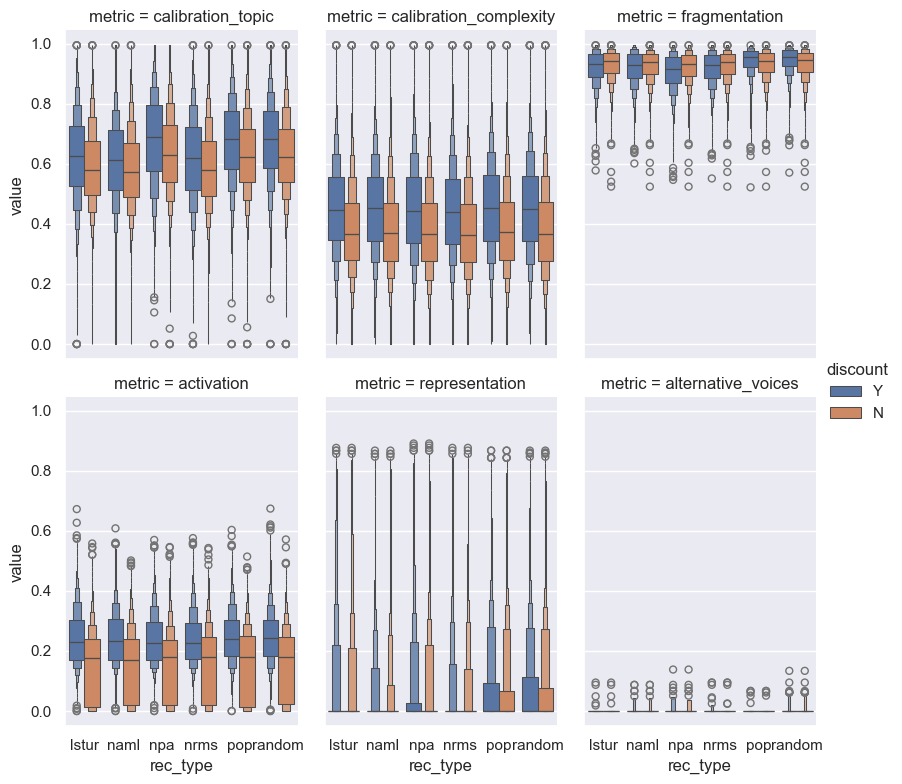

CPU times: total: 1h 45min 16s
Wall time: 1h 46min 26s


In [64]:
%%time
df = calculator.execute()

In [65]:
# Exportación mía
df.to_pickle("_TFM/output/df_calculator.pkl")

RADio attempts to capture five normative concepts in news reccomendations. These are:
- Calibration (topics): Article subcategories as provided in the MIND dataset
- Calibration (complexity): article complexity as calculated with the Flesh-Kincaid reading ease tes
- Fragmentation: Recommended news story chains, which are identified following the procedure in (ADD!!!)
- Activation: affect scores, which is approximated by the absolute value of a sentinetnt analysis score
- Representation: The presence of political actors
- Alternative voices: the presence of minority voices versus majordity voices. We identifty someone asa minority voice when they are identified as a person through the NLP pipeline, but cannot be linked toa wikipedia page

In [66]:
df.head(16)

,impr_index,rec_type,cutoff,distance,discount,metric,value
0,72100,lstur,1,kl,Y,calibration_topic,6.694116
1,72100,lstur,1,jsd,Y,calibration_topic,0.717474
2,72100,lstur,1,kl,N,calibration_topic,6.688182
3,72100,lstur,1,jsd,N,calibration_topic,0.716872
4,72100,lstur,1,kl,Y,calibration_complexity,9.214063
5,72100,lstur,1,jsd,Y,calibration_complexity,0.918692
6,72100,lstur,1,kl,N,calibration_complexity,8.554538
7,72100,lstur,1,jsd,N,calibration_complexity,0.861087
8,72100,lstur,1,kl,Y,fragmentation,5.236610
9,72100,lstur,1,jsd,Y,fragmentation,0.894510


In [71]:
# Cargar fichero guardado
df_loaded = pd.read_pickle("_TFM/output/df_calculator.pkl")

df = df_loaded
df.head(16)

,impr_index,rec_type,cutoff,distance,discount,metric,value
0,72100,lstur,1,kl,Y,calibration_topic,6.694116
1,72100,lstur,1,jsd,Y,calibration_topic,0.717474
2,72100,lstur,1,kl,N,calibration_topic,6.688182
3,72100,lstur,1,jsd,N,calibration_topic,0.716872
4,72100,lstur,1,kl,Y,calibration_complexity,9.214063
5,72100,lstur,1,jsd,Y,calibration_complexity,0.918692
6,72100,lstur,1,kl,N,calibration_complexity,8.554538
7,72100,lstur,1,jsd,N,calibration_complexity,0.861087
8,72100,lstur,1,kl,Y,fragmentation,5.236610
9,72100,lstur,1,jsd,Y,fragmentation,0.894510


Values in the framework, are measured on two scales. For the purpose of this workshop, only the Jensen Shannon divergence is used, since this is a normalized value and allows for more intuitive comparison

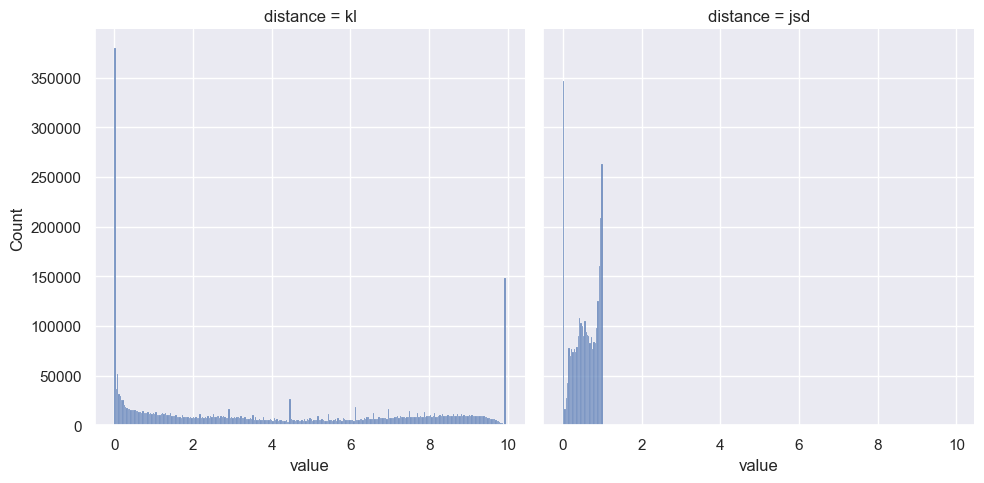

In [68]:
sns.displot(data=df, x="value", col="distance", kde=False)
plt.show()

In [72]:
df = df[df['distance'] == 'jsd']
df.head(10)

,impr_index,rec_type,cutoff,distance,discount,metric,value
1,72100,lstur,1,jsd,Y,calibration_topic,0.717474
3,72100,lstur,1,jsd,N,calibration_topic,0.716872
5,72100,lstur,1,jsd,Y,calibration_complexity,0.918692
7,72100,lstur,1,jsd,N,calibration_complexity,0.861087
9,72100,lstur,1,jsd,Y,fragmentation,0.894510
11,72100,lstur,1,jsd,N,fragmentation,0.927607
13,72100,lstur,1,jsd,Y,activation,0.483757
15,72100,lstur,1,jsd,N,activation,0.483760
17,72100,lstur,2,jsd,Y,calibration_topic,0.717478
19,72100,lstur,2,jsd,N,calibration_topic,0.716872


All values theoretically range from 0-1 now.

In [70]:
for metric in df['metric'].unique():
    
    min = df[df['metric'] == metric]["value"].min()
    max = df[df['metric'] == metric]["value"].max()
    print(f'{metric.upper()}: ranges from {min} to {max}')

CALIBRATION_TOPIC: ranges from 0.0 to 0.9942797605616539
CALIBRATION_COMPLEXITY: ranges from 0.0 to 0.9942797605616537
FRAGMENTATION: ranges from 0.43987746567184266 to 0.9942797605616539
ACTIVATION: ranges from 0.0 to 0.9819650333006957
REPRESENTATION: ranges from 0.0 to 0.9141393272621361
ALTERNATIVE_VOICES: ranges from 0.0 to 0.1381658498594735


Multiple algorithms are used in the framework to estimate these values. These algorithms are
- LSTUR
- NAML
- NPA
- NRMS
- Most popular
- Random
  
The differences in the values can be retrieved by the following:

CALIBRATION_TOPIC
lstur: 0.656471489362728
naml: 0.6424622354457283
npa: 0.6991793159439591
nrms: 0.6469121128275429
pop: 0.7005046696248118
random: 0.7014599642878989
CALIBRATION_COMPLEXITY
lstur: 0.49710116883175703
naml: 0.49683158058720794
npa: 0.49398815073344765
nrms: 0.4928170649119414
pop: 0.49827232139665306
random: 0.4970878686090133
FRAGMENTATION
lstur: 0.9331343994392133
naml: 0.9329817330942378
npa: 0.9285897208601943
nrms: 0.9327590898341637
pop: 0.944832293035175
random: 0.9463186281894347
ACTIVATION
lstur: 0.2976134494425953
naml: 0.29900940413377547
npa: 0.29477833817708754
nrms: 0.29144667734239926
pop: 0.3004040088106471
random: 0.3001899242869967
REPRESENTATION
lstur: 0.0478453541202643
naml: 0.034240265998693044
npa: 0.048346412946535605
nrms: 0.03720415241557682
pop: 0.05813938902123662
random: 0.05981915029494713
ALTERNATIVE_VOICES
lstur: 0.0005321642835782499
naml: 0.00076045337706291
npa: 0.0015290894685543901
nrms: 0.000968970682035393
pop: 0.00080570163283582

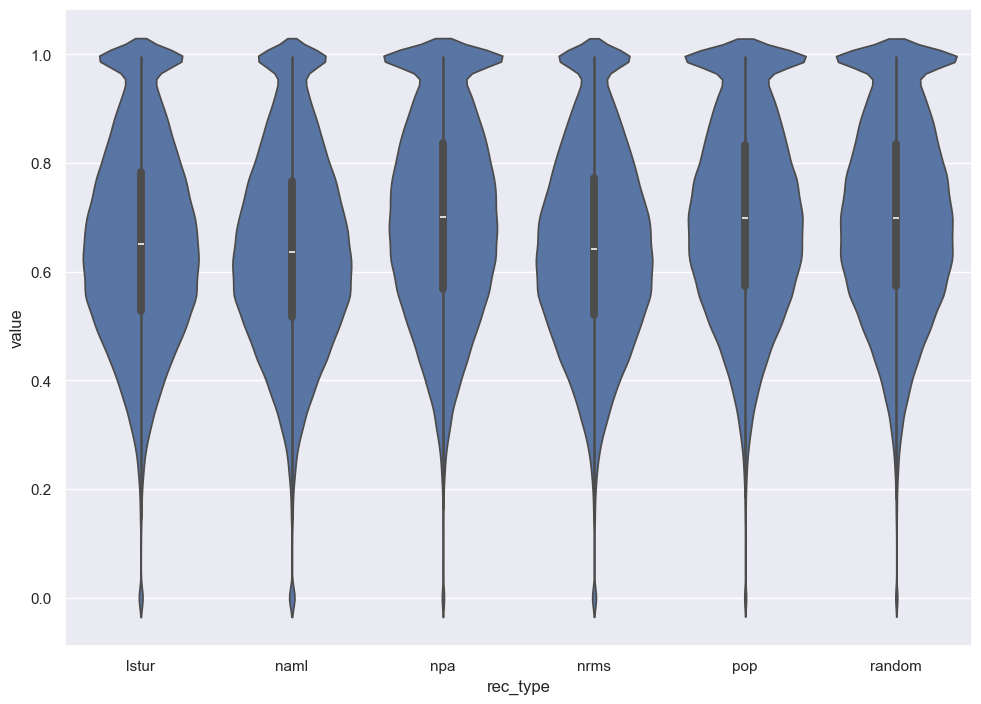

In [72]:
for metric in df['metric'].unique():
    print(metric.upper())
    for rec in df['rec_type'].unique():
        mean = df[df['metric'] == metric][df["rec_type"] == rec]["value"].mean()
        print(f'{rec}: {mean}')
# Notice that, due to the normalized values, the differences in algorithms can also easily be interpreted!
sns.violinplot(data=df[df["metric"] == "calibration_topic"], x="rec_type", y="value")

tabledata = df[df['discount'] == "Y"]
table = pd.DataFrame(columns=['Algorithms'])
table = table.set_index('Algorithms')
for metric in tabledata['metric'].unique():
    for rec in tabledata['rec_type'].unique():
        mean = tabledata[tabledata['metric'] == metric][tabledata["rec_type"] == rec]["value"].mean()
        table.at[rec, metric] = mean
table
plt.show()

Finally, the framework differentate between reccomender systems that takes ranking into account. That is: something displayed at the top, is seen as more valuable. And also how many are displayed to the user known as the cutoff.

In [73]:
print("Means of 'calibration_topic' for rank awareness")
for discount in df['discount'].unique():
    mean = df[df['metric'] == 'calibration_topic'][df['discount'] == discount]["value"].mean()
    print(f'{discount}: {mean}')

print("Means of 'calibration_topic' for different cutoff points")
for cutoff in df['cutoff'].unique():
    mean = df[df['metric'] == 'calibration_topic'][df['cutoff'] == cutoff]["value"].mean()
    print(f'{cutoff}: {mean}')

Means of 'calibration_topic' for rank awareness
Y: 0.687671114598887
N: 0.6613254812320026
Means of 'calibration_topic' for different cutoff points
1: 0.8082538234652954
2: 0.7524167348025443
5: 0.6769903534943109
10: 0.6282808815005331
20: 0.5977263875405475
0: 0.583321606689438


Algorithms generate different resulting values per cutoff point as shown below

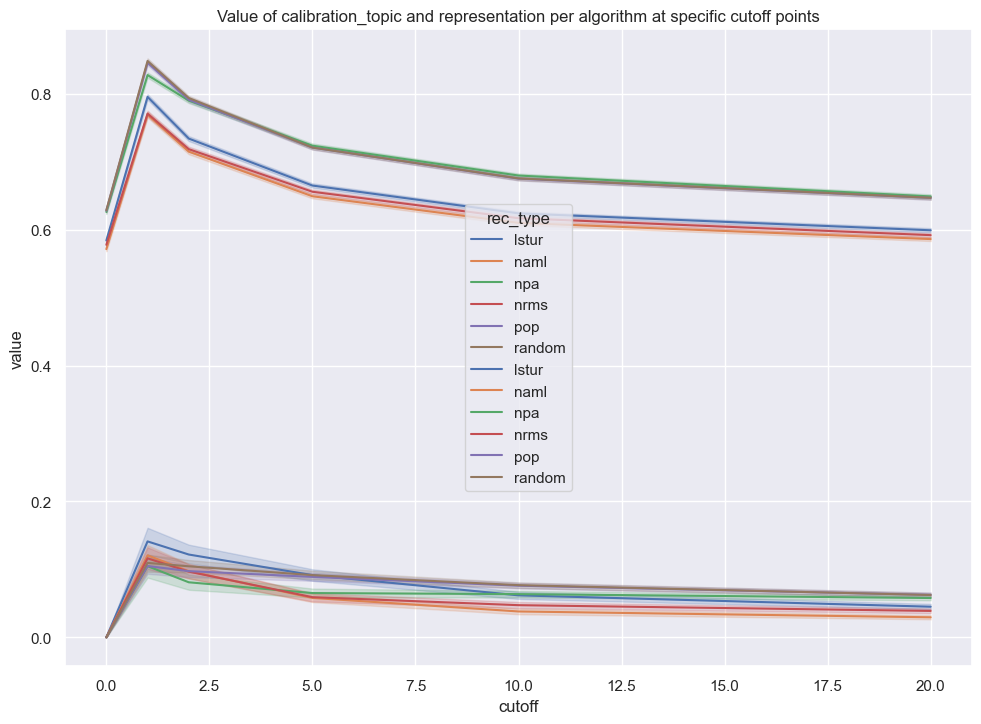

In [74]:
sns.lineplot(
    data=df[df['metric'] == 'calibration_topic'][df['discount'] == 'Y'],
    x="cutoff", y="value", hue="rec_type",
    markers=True, dashes=False
)
sns.lineplot(
    data=df[df['metric'] == 'representation'][df['discount'] == 'N'],
    x="cutoff", y="value", hue="rec_type",
    markers=True, dashes=False
).set_title('Value of calibration_topic and representation per algorithm at specific cutoff points')
plt.show()

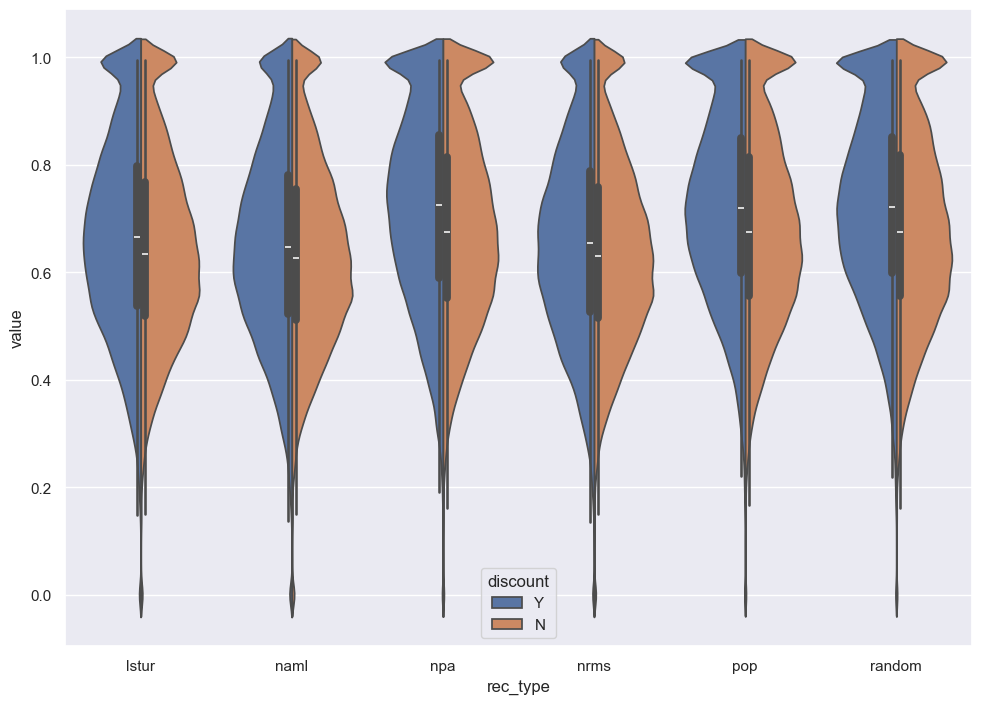

In [75]:
#RANDOM
sns.violinplot(data=df[df["metric"] == "calibration_topic"], x="rec_type", y="value", hue = 'discount', split=True)
plt.show()

## Spiderplots

For the implementation of this part, the parameters `cutoff = 10`, `discount = 'Y'`, and `distance = jsd` (with `jsd` already computed previously) are used, as this configuration is the most consistent with the recommender under consideration.

Since the only metric for which values close to 1 are considered “better” is **Fragmentation**, it is inverted by computing `frag = 1 - frag` so that the spider plots are more intuitive, given that for the remaining metrics values close to 0 are considered “better”.

Furthermore, as the metric compares against the displayed impression in the cases of **Alternative Voices**, **Activation**, and **Representation**, with a **cutoff of 10** it is necessary for the impression to contain at least **40 articles** to ensure a reasonable calculation. Otherwise, if both lists contain ≤10 articles, these metrics will be practically 0, since the same articles will be compared in both parts. For **Calibration (topics and complexity)** and **Fragmentation**, no truncation is required, as they compare against the **reading history** or against **other users**, respectively.

In [73]:
# Lista de [impression_index, len(items_without_click)]
impression_lengths = [[entry['impression_index'], len(entry['items_without_click'])]
                      for entry in behavior_file]
print(impression_lengths[1])

[2, 7]


In [74]:
total_impressions = len(impression_lengths)
count_ge_40 = sum(1 for _, length in impression_lengths if length >= 40)

print(f"Número de impresiones con >= 40 artículos: {count_ge_40} de un total de {total_impressions}")

Número de impresiones con >= 40 artículos: 24003 de un total de 73152


In [75]:
df = df[df['cutoff'] == 10]
df.head(10)

,impr_index,rec_type,cutoff,distance,discount,metric,value
53,72100,lstur,10,jsd,Y,calibration_topic,0.578572
55,72100,lstur,10,jsd,N,calibration_topic,0.503352
57,72100,lstur,10,jsd,Y,calibration_complexity,0.434069
59,72100,lstur,10,jsd,N,calibration_complexity,0.246841
61,72100,lstur,10,jsd,Y,fragmentation,0.858977
63,72100,lstur,10,jsd,N,fragmentation,0.834330
65,72100,lstur,10,jsd,Y,activation,0.137643
67,72100,lstur,10,jsd,N,activation,0.000000
69,72100,lstur,10,jsd,Y,representation,0.000000
71,72100,lstur,10,jsd,N,representation,0.000000


In [76]:
df = df[df['discount'] == 'Y']
df.head(10)

,impr_index,rec_type,cutoff,distance,discount,metric,value
53,72100,lstur,10,jsd,Y,calibration_topic,0.578572
57,72100,lstur,10,jsd,Y,calibration_complexity,0.434069
61,72100,lstur,10,jsd,Y,fragmentation,0.858977
65,72100,lstur,10,jsd,Y,activation,0.137643
69,72100,lstur,10,jsd,Y,representation,0.000000
165,72100,naml,10,jsd,Y,calibration_topic,0.588203
169,72100,naml,10,jsd,Y,calibration_complexity,0.450568
173,72100,naml,10,jsd,Y,fragmentation,0.859943
177,72100,naml,10,jsd,Y,activation,0.162946
181,72100,naml,10,jsd,Y,representation,0.000000


In [77]:
df.drop(columns=['cutoff', 'distance', 'discount'], inplace=True)
df.head()

,impr_index,rec_type,metric,value
53,72100,lstur,calibration_topic,0.578572
57,72100,lstur,calibration_complexity,0.434069
61,72100,lstur,fragmentation,0.858977
65,72100,lstur,activation,0.137643
69,72100,lstur,representation,0.000000


In [78]:
# Convertimos la lista a DataFrame
df_lengths = pd.DataFrame(impression_lengths, columns=['impr_index', 'impression_length'])

# Hacemos un join con df usando la columna impr_index
df = df.merge(df_lengths, on='impr_index', how='left')

In [79]:
# Ahora df tendrá la columna 'impression_length' con el tamaño de items_without_click
df.head(10)

,impr_index,rec_type,metric,value,impression_length
0,72100,lstur,calibration_topic,0.578572,5
1,72100,lstur,calibration_complexity,0.434069,5
2,72100,lstur,fragmentation,0.858977,5
3,72100,lstur,activation,0.137643,5
4,72100,lstur,representation,0.000000,5
5,72100,naml,calibration_topic,0.588203,5
6,72100,naml,calibration_complexity,0.450568,5
7,72100,naml,fragmentation,0.859943,5
8,72100,naml,activation,0.162946,5
9,72100,naml,representation,0.000000,5


In [80]:
# Métricas sujetas al corte
#metrics_cut = ['activation', 'representation', 'alternative_voices']

# Eliminamos únicamente las filas que cumplen ambas condiciones
# df_filtered = df[~(
#     (df['metric'].isin(metrics_cut)) &
#     (df['impression_length'] < 40)
# )]

# Para evitar fallos, eliminamos todas aquellas con impression_length<40, ya que si solo eliminamos las de las metrics_cut, luego falla
df_filtered = df[~(df['impression_length'] < 40)]

df = df_filtered

df.head(10)

,impr_index,rec_type,metric,value,impression_length
30,31734,lstur,fragmentation,0.981357,48
31,31734,lstur,activation,0.343668,48
32,31734,naml,fragmentation,0.948197,48
33,31734,naml,activation,0.253335,48
34,31734,npa,fragmentation,0.936005,48
35,31734,npa,activation,0.155936,48
36,31734,nrms,fragmentation,0.961105,48
37,31734,nrms,activation,0.236595,48
38,31734,pop,fragmentation,0.981126,48
39,31734,pop,activation,0.231958,48


In [81]:
# Hacemos frag = abs(1-frag)
df.loc[df['metric'] == 'fragmentation', 'value'] = \
    (1 - df.loc[df['metric'] == 'fragmentation', 'value']).abs()
df.head(10)

,impr_index,rec_type,metric,value,impression_length
30,31734,lstur,fragmentation,0.018643,48
31,31734,lstur,activation,0.343668,48
32,31734,naml,fragmentation,0.051803,48
33,31734,naml,activation,0.253335,48
34,31734,npa,fragmentation,0.063995,48
35,31734,npa,activation,0.155936,48
36,31734,nrms,fragmentation,0.038895,48
37,31734,nrms,activation,0.236595,48
38,31734,pop,fragmentation,0.018874,48
39,31734,pop,activation,0.231958,48


In [82]:
df.drop(columns=['impression_length'], inplace=True)
df.head()

,impr_index,rec_type,metric,value
30,31734,lstur,fragmentation,0.018643
31,31734,lstur,activation,0.343668
32,31734,naml,fragmentation,0.051803
33,31734,naml,activation,0.253335
34,31734,npa,fragmentation,0.063995


#### Baseline per recommender

In [83]:
# ---------------------------
# 1. Agregar por rec_type y metric
# ---------------------------
df_agg = df.groupby(["rec_type", "metric"])["value"].mean().reset_index()

# ---------------------------
# 2. Pivotear para tener una fila por rec_type y columnas = métricas
# ---------------------------
df_final = df_agg.pivot(index="rec_type", columns="metric", values="value").fillna(0)

In [84]:
df_final.head()

metric,activation,alternative_voices,calibration_complexity,calibration_topic,fragmentation,representation
rec_type,,,,,,
lstur,0.292663,0.003292,0.429000,0.601719,0.060940,0.208471
naml,0.288715,0.004123,0.430865,0.586527,0.061017,0.152795
npa,0.270022,0.014292,0.416376,0.675013,0.076290,0.193354
nrms,0.280909,0.003189,0.423091,0.588221,0.059454,0.162884
pop,0.286677,0.002418,0.431220,0.676273,0.031845,0.189490


In [85]:
def make_spider(rec_type, row):
    metrics = row.index.tolist()
    values = row.values.astype(float)

    # cerrar polígono
    values = np.concatenate([values, values[:1]])
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(f"Spiderplot – {rec_type}", pad=20, fontsize=14)

    plt.show()

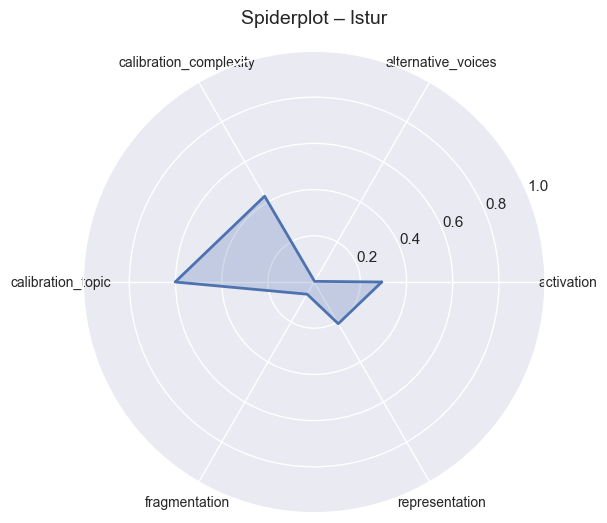

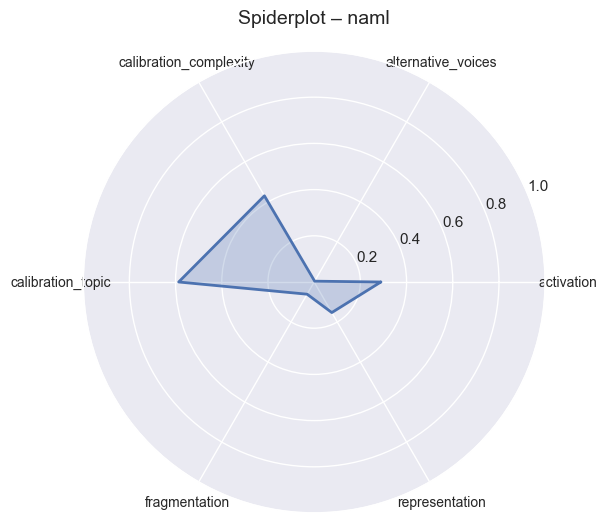

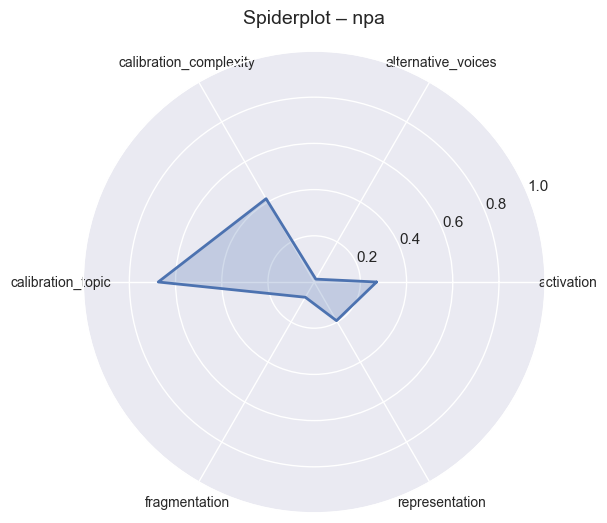

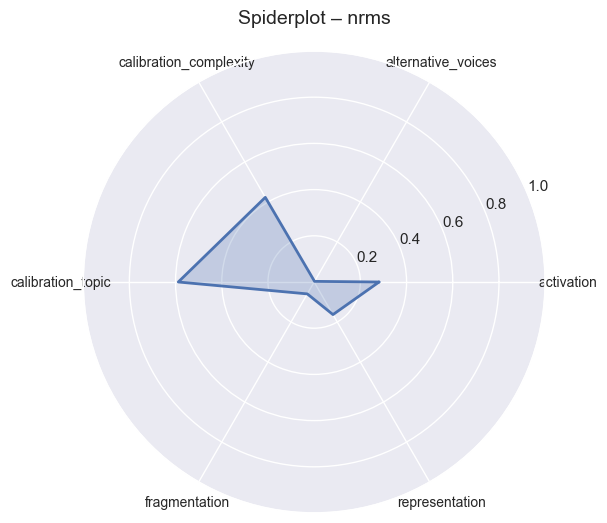

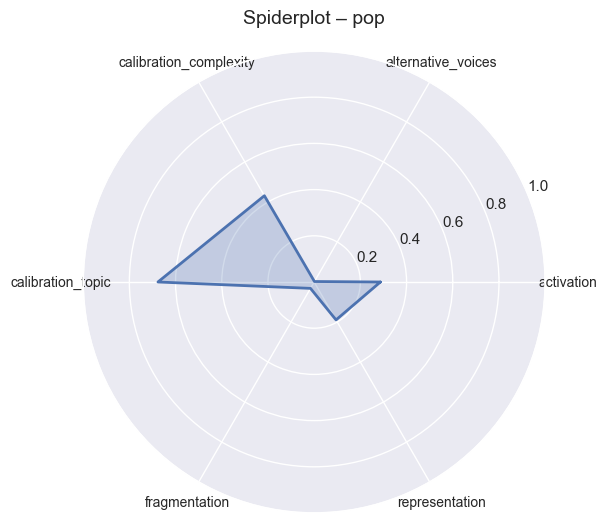

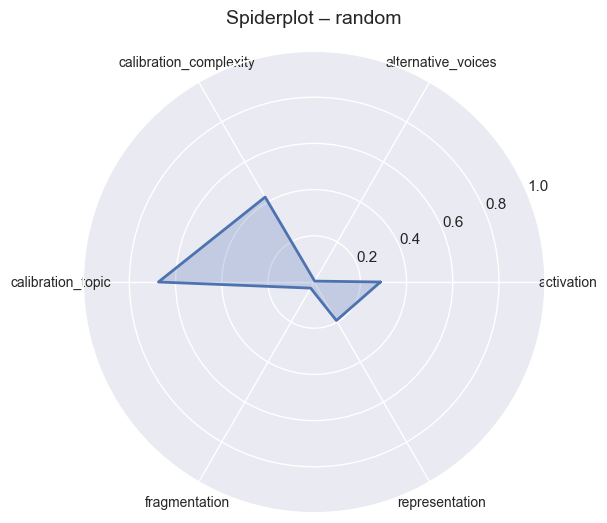

In [86]:
for rec_type, row in df_final.iterrows():
    make_spider(rec_type, row)

#### User clusters: clustering by user, averaged over recommendation types

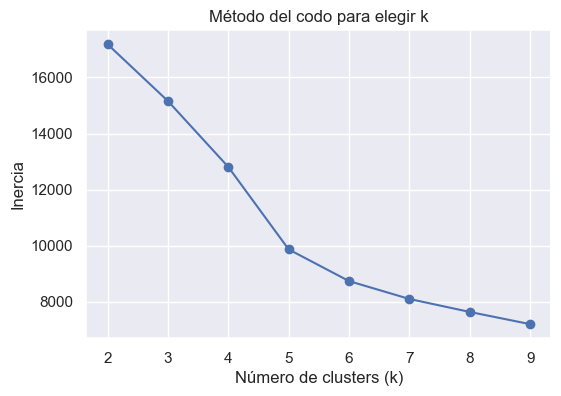

In [87]:
###############################################################################
# PASO 1 — Agregar por usuario y métrica
# (media por impr_index ignorando el rec_type)
###############################################################################

df_user = (
    df.groupby(["impr_index", "metric"])["value"]
      .mean()
      .reset_index()
)


###############################################################################
# PASO 2 — Crear matriz usuario × métrica (pivotear)
###############################################################################

df_user_wide = (
    df_user.pivot(index="impr_index", columns="metric", values="value")
           .fillna(0)      # por si faltan métricas para algunos usuarios
)


###############################################################################
# PASO 3 — Estandarizar las variables para clustering
###############################################################################

scaler = StandardScaler()
X = scaler.fit_transform(df_user_wide)


###############################################################################
# PASO 4 — Método del codo para elegir k (opcional pero recomendado)
###############################################################################

inertia = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo para elegir k")
plt.show()

In [88]:
###############################################################################
# PASO 5 — Aplicar K-Means con el número de clusters elegido-->5
###############################################################################

k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(X)

df_user_wide["cluster"] = labels


###############################################################################
# PASO 6 — Resultado final listo para graficar spiderplots por cluster
###############################################################################

print(df_user_wide.head())

# df_user_wide ahora tiene:
# - Una fila por usuario (impr_index)
# - Una columna por métrica
# - Una columna "cluster" con el cluster asignado

metric      activation  alternative_voices  calibration_complexity  \
impr_index                                                           
58            0.289392        8.949059e-09                0.312717   
99            0.359201        4.474530e-09                0.493449   
148           0.314294        0.000000e+00                0.359719   
157           0.314906        0.000000e+00                0.452854   
197           0.200919        0.000000e+00                0.293088   

metric      calibration_topic  fragmentation  representation  cluster  
impr_index                                                             
58                   0.590344       0.055963        0.000000        0  
99                   0.384635       0.050796        0.191259        0  
148                  0.787525       0.047562        0.000000        0  
157                  0.543255       0.062323        0.000000        0  
197                  0.713870       0.053919        0.817768        2  


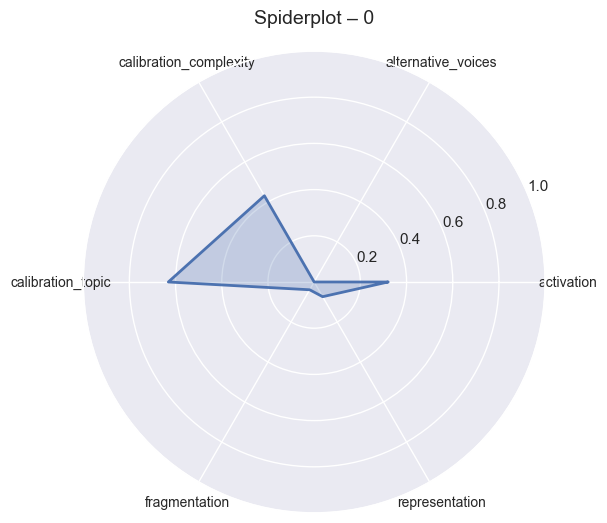

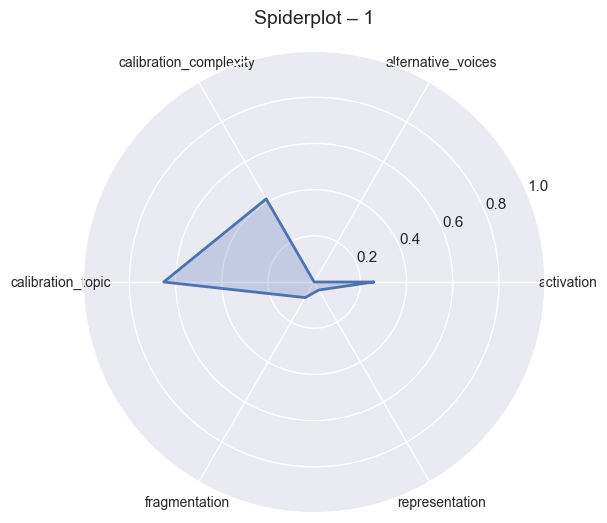

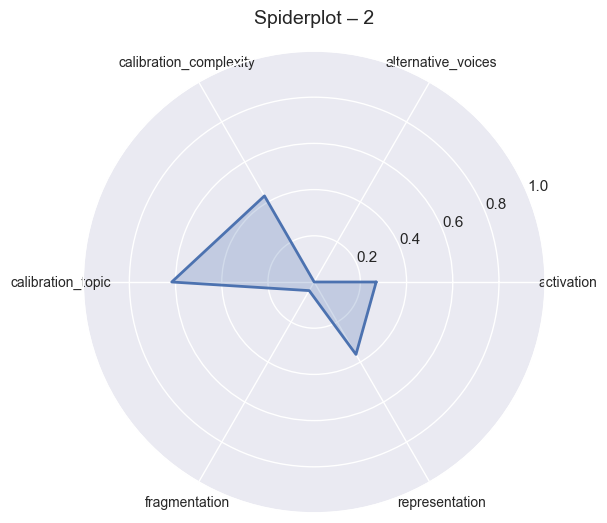

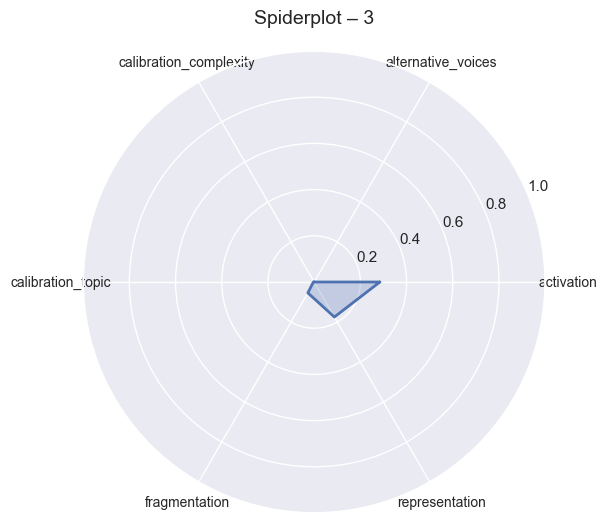

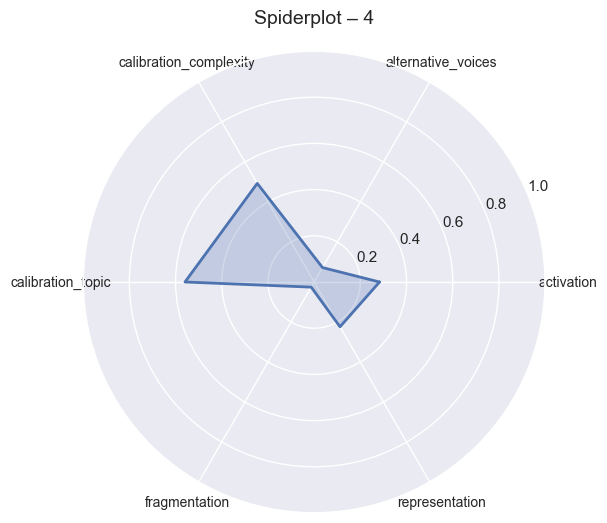

In [89]:
###############################################################################
# PASO 1 — Calcular la media de cada métrica por cluster
###############################################################################

df_cluster_mean = (
    df_user_wide.groupby("cluster")
                .mean(numeric_only=True)  # solo columnas numéricas
)

# Ordenar las métricas para que la forma sea consistente
metrics = df_cluster_mean.columns.tolist()


###############################################################################
# PASO 2 — Función para generar un spiderplot de un cluster
###############################################################################

def make_spider_users(cluster_id, row):
    values = row.values.astype(float)
    
    # cerrar la forma del radar
    values = np.concatenate([values, values[:1]])
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    # crear figura
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # plot
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    # etiquetas de métricas
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=10)

    # límites
    ax.set_ylim(0, 1)

    ax.set_title(f"Spiderplot – Cluster {cluster_id}", pad=20)

    plt.show()


###############################################################################
# PASO 3 — Generar un spiderplot por cada cluster
###############################################################################

for cluster_id, row in df_cluster_mean.iterrows():
    make_spider(cluster_id, row)